# Facebook Prophet Time Series Forecasting

*Prophet is a very powerful easy to use forecasting algorithm with many paramters to tune to specific business cases. Whilst it tries to autodetect many paramters many paramters can be set for imporved performance*

Facebook Prophet is a time-series forecasting library developed by Facebook. It is designed to make it easy for analysts and developers to create accurate forecasts for a wide range of time-series data such as sales, weather, and stock prices. It is based on an additive regression model that incorporates features such as trends, seasonality, and holidays. Prophet also has built-in functionality for handling missing data and outliers. It is widely used in industries such as finance, retail, and healthcare for forecasting and decision-making purposes.

Facebook Prophet is a time series forecasting model developed by Facebook that uses a generalized additive model (GAM) to make predictions. It is similar to ARIMA in that it can model time series data with seasonality and trends. However, Prophet has some advantages over ARIMA in terms of ease of use and performance.

One advantage of Prophet is that it does not require as much domain knowledge or manual feature engineering as ARIMA, as it can automatically detect and model seasonality and trends. Additionally, Prophet is often faster to train and can handle missing data more easily than ARIMA.

That being said, ARIMA is a more traditional and widely used time series forecasting model, and may still be a better choice for certain applications or data sets. It ultimately depends on the specific needs and characteristics of the problem at hand.

In [9]:
# !pip install prophet

In [9]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [10]:
X = pd.read_csv('https://github.com/DrPBaksh/workshop-data/blob/main/temperature_load.csv?raw=true')
X.date_time = pd.to_datetime(X.date_time)
X.head()

,date_time,total load actual,temp_mean,date,time
0,2015-01-01 00:00:00,25385.0,270.475,2015-01-01,00:00:00
1,2015-01-01 01:00:00,24382.0,270.475,2015-01-01,01:00:00
2,2015-01-01 02:00:00,22734.0,269.686,2015-01-01,02:00:00
3,2015-01-01 03:00:00,21286.0,269.686,2015-01-01,03:00:00
4,2015-01-01 04:00:00,20264.0,269.686,2015-01-01,04:00:00


**We shall use 95% of our data for training and 5% for testing which is the most recent data points**

In [11]:
thresh = 0.95 #  95 % of the data used for training

X_train = X.iloc[:int(len(X) * thresh), :]
X_test = X.iloc[int(len(X) * thresh):, :]


**NOTE : Prophet takes a dataframe as its input. It will specifically require that the date component column be caled 'ds'. It specifcally requires the target component to be called 'y'**

In [12]:
X_train = X_train[['date_time','total load actual']]
X_train = X_train.rename(columns = {'date_time': 'ds', 'total load actual':'y'})

**Initially we shall call our model m and fit our data to Prophet with no paramters. Later in this notebook we can go through these parameters**

In [13]:
m = Prophet()
m.fit(X_train)

06:20:18 - cmdstanpy - INFO - Chain [1] start processing
06:20:39 - cmdstanpy - INFO - Chain [1] done processing


**Once the data is fited to Prophet making a forecast is simple. Be clear to set the frequency of points at which you want your forecast. By default it may not forecast at the frequency of the data you used to train it. Use the same frequency codes you would to set any time series data in pandas. Also note to set the number of forecast periods required**

In [14]:
# Make future predictions
future = m.make_future_dataframe(periods=len(X_test), freq='H')
forecast = m.predict(future)

**Visualise the forecast**

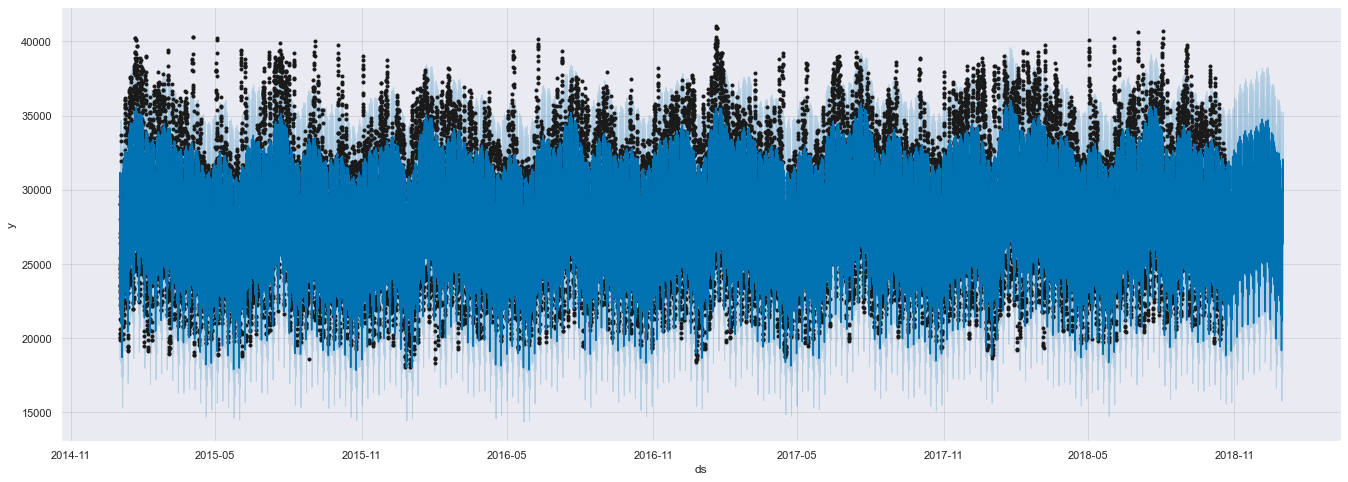

In [15]:
fig = m.plot(forecast)
fig = plt.gcf()
fig.set_size_inches(20, 7)

**Visualise just the forecast region and compare against the true result**

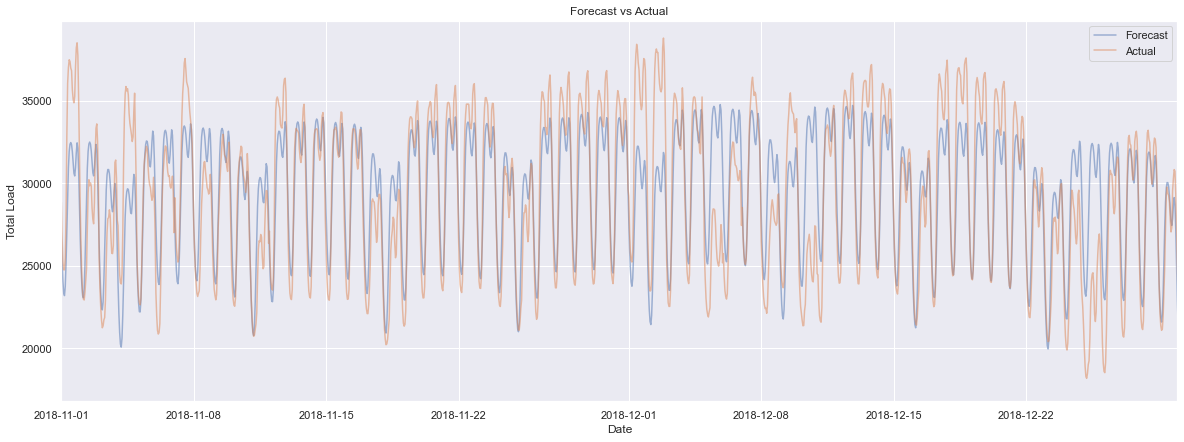

In [16]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast', alpha = 0.5)
ax.plot(X_test['date_time'], X_test['total load actual'], label='Actual', alpha = 0.5)
ax.set_xlim([pd.to_datetime('2018-11-01'), pd.to_datetime('2018-12-30')])
ax.set_title('Forecast vs Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Total Load')
ax.legend()
plt.show()


**By eye this looks pretty impressive! Lets now put some quantitive metrics to this**

In [17]:
import numpy as np
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def evaluate_forecast(y_pred, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2 Score: {r2:.2f}")
    return rmse, mape, r2


**Merge the forecast and true results into one dataframe based on date**

In [18]:
test_pred = X_test.merge(forecast[['yhat', 'ds']], left_on = 'date_time', right_on = 'ds')
evaluate_forecast(test_pred.yhat,test_pred['total load actual'])

RMSE: 2565.25
MAPE: 6.69%
R2 Score: 0.70


(2565.2454882536576, 6.68689609257727, 0.7041837441586682)

**This looks pretty good for the forecast. However we note we had temperature infomation in the initial data. Can Prophet deal with exogenous variables? Well yes. Lets look how and if it improves this forecast** Lets bring in the data again

In [19]:
thresh = 0.95 #  95 % of the data used for training
X_train = X.iloc[:int(len(X) * thresh), :]
X_test = X.iloc[int(len(X) * thresh):, :]
X_train.head()
# X_train = X_train[['date_time','total load actual']]
# X_train = X_train.rename(columns = {'date_time': 'ds', 'total load actual':'y'})

,date_time,total load actual,temp_mean,date,time
0,2015-01-01 00:00:00,25385.0,270.475,2015-01-01,00:00:00
1,2015-01-01 01:00:00,24382.0,270.475,2015-01-01,01:00:00
2,2015-01-01 02:00:00,22734.0,269.686,2015-01-01,02:00:00
3,2015-01-01 03:00:00,21286.0,269.686,2015-01-01,03:00:00
4,2015-01-01 04:00:00,20264.0,269.686,2015-01-01,04:00:00


In [20]:
X_train = X_train[['date_time','total load actual', 'temp_mean']]
X_train = X_train.rename(columns = {'date_time': 'ds', 'total load actual':'y'})

In [21]:
X_train.head()

,ds,y,temp_mean
0,2015-01-01 00:00:00,25385.0,270.475
1,2015-01-01 01:00:00,24382.0,270.475
2,2015-01-01 02:00:00,22734.0,269.686
3,2015-01-01 03:00:00,21286.0,269.686
4,2015-01-01 04:00:00,20264.0,269.686


In [22]:
m = Prophet()
m.add_regressor('temp_mean')
m.fit(X_train)

06:20:51 - cmdstanpy - INFO - Chain [1] start processing
06:21:13 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = m.make_future_dataframe(periods=len(X_test), freq='H')
future['temp_mean'] = X.temp_mean
forecast = m.predict(future)

In [24]:
forecast = forecast.rename(columns=lambda x: x + '_exog')


In [25]:
test_pred = test_pred.merge(forecast[['yhat_exog', 'ds_exog']], left_on = 'date_time', right_on = 'ds_exog')
evaluate_forecast(test_pred.yhat_exog,test_pred['total load actual'])

RMSE: 2564.00
MAPE: 6.69%
R2 Score: 0.70


(2564.002011091867, 6.691186451547142, 0.704470462608298)

**Did we do better for using exog variables. YES!! but not by much the RMSE went from 2565 down to 2564, whilst all other metrics stayed the same. Lets view what this looks like below**

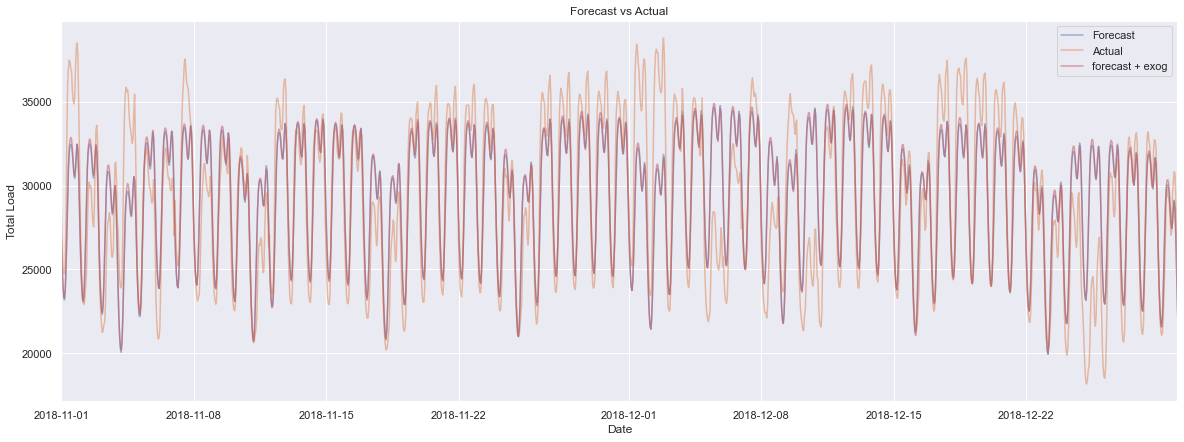

In [27]:

sns.set()
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(test_pred['ds'], test_pred['yhat'], label='Forecast', alpha = 0.5)
ax.plot(test_pred['date_time'], test_pred['total load actual'], label='Actual', alpha = 0.5)
ax.plot(test_pred['date_time'], test_pred['yhat_exog'],'r',  label='forecast + exog',alpha = 0.5)
ax.set_xlim([pd.to_datetime('2018-11-01'), pd.to_datetime('2018-12-30')])
ax.set_title('Forecast vs Actual')
ax.set_xlabel('Date')
ax.set_ylabel('Total Load')
ax.legend()
plt.show()

**Lets have a look at the other bits of infomation we can extract from the forecast**

In [28]:
forecast.columns

Index(['ds_exog', 'trend_exog', 'yhat_lower_exog', 'yhat_upper_exog',
       'trend_lower_exog', 'trend_upper_exog', 'additive_terms_exog',
       'additive_terms_lower_exog', 'additive_terms_upper_exog', 'daily_exog',
       'daily_lower_exog', 'daily_upper_exog',
       'extra_regressors_additive_exog',
       'extra_regressors_additive_lower_exog',
       'extra_regressors_additive_upper_exog', 'temp_mean_exog',
       'temp_mean_lower_exog', 'temp_mean_upper_exog', 'weekly_exog',
       'weekly_lower_exog', 'weekly_upper_exog', 'yearly_exog',
       'yearly_lower_exog', 'yearly_upper_exog', 'multiplicative_terms_exog',
       'multiplicative_terms_lower_exog', 'multiplicative_terms_upper_exog',
       'yhat_exog'],
      dtype='object')

- ds: the date/time index of the forecast
- trend: the overall trend (or growth/decay) in the time series
- yhat_lower: the lower bound of the predicted values (by default, a 80% prediction interval is generated)
- yhat_upper: the upper bound of the predicted values
- trend_lower: the lower bound of the overall trend
- trend_upper: the upper bound of the overall trend
- additive_terms: additional effects (holidays, seasonality, etc.) that were added to the trend to generate the forecast
- additive_terms_lower: the lower bound of the additional effects
- additive_terms_upper: the upper bound of the additional effects
- daily: the estimated effect of daily seasonality
- daily_lower: the lower bound of the estimated effect of daily seasonality
- daily_upper: the upper bound of the estimated effect of daily seasonality
- weekly: the estimated effect of weekly seasonality
- weekly_lower: the lower bound of the estimated effect of weekly seasonality
- weekly_upper: the upper bound of the estimated effect of weekly seasonality
- yearly: the estimated effect of yearly seasonality
- yearly_lower: the lower bound of the estimated effect of yearly seasonality
- yearly_upper: the upper bound of the estimated effect of yearly seasonality
- multiplicative_terms: additional effects that were multiplied with the trend to generate the forecast (only included if the input data includes a -column named 'multiplicative_terms')
- multiplicative_terms_lower: the lower bound of the additional effects that were multiplied with the trend
- multiplicative_terms_upper: the upper bound of the additional effects that were multiplied with the trend
- yhat: the predicted values (the sum of the trend, additive effects, and any multiplicative effects)

Lets plot all of these in a grid plot and see what we think


In [29]:
forecast.columns.shape

(28,)

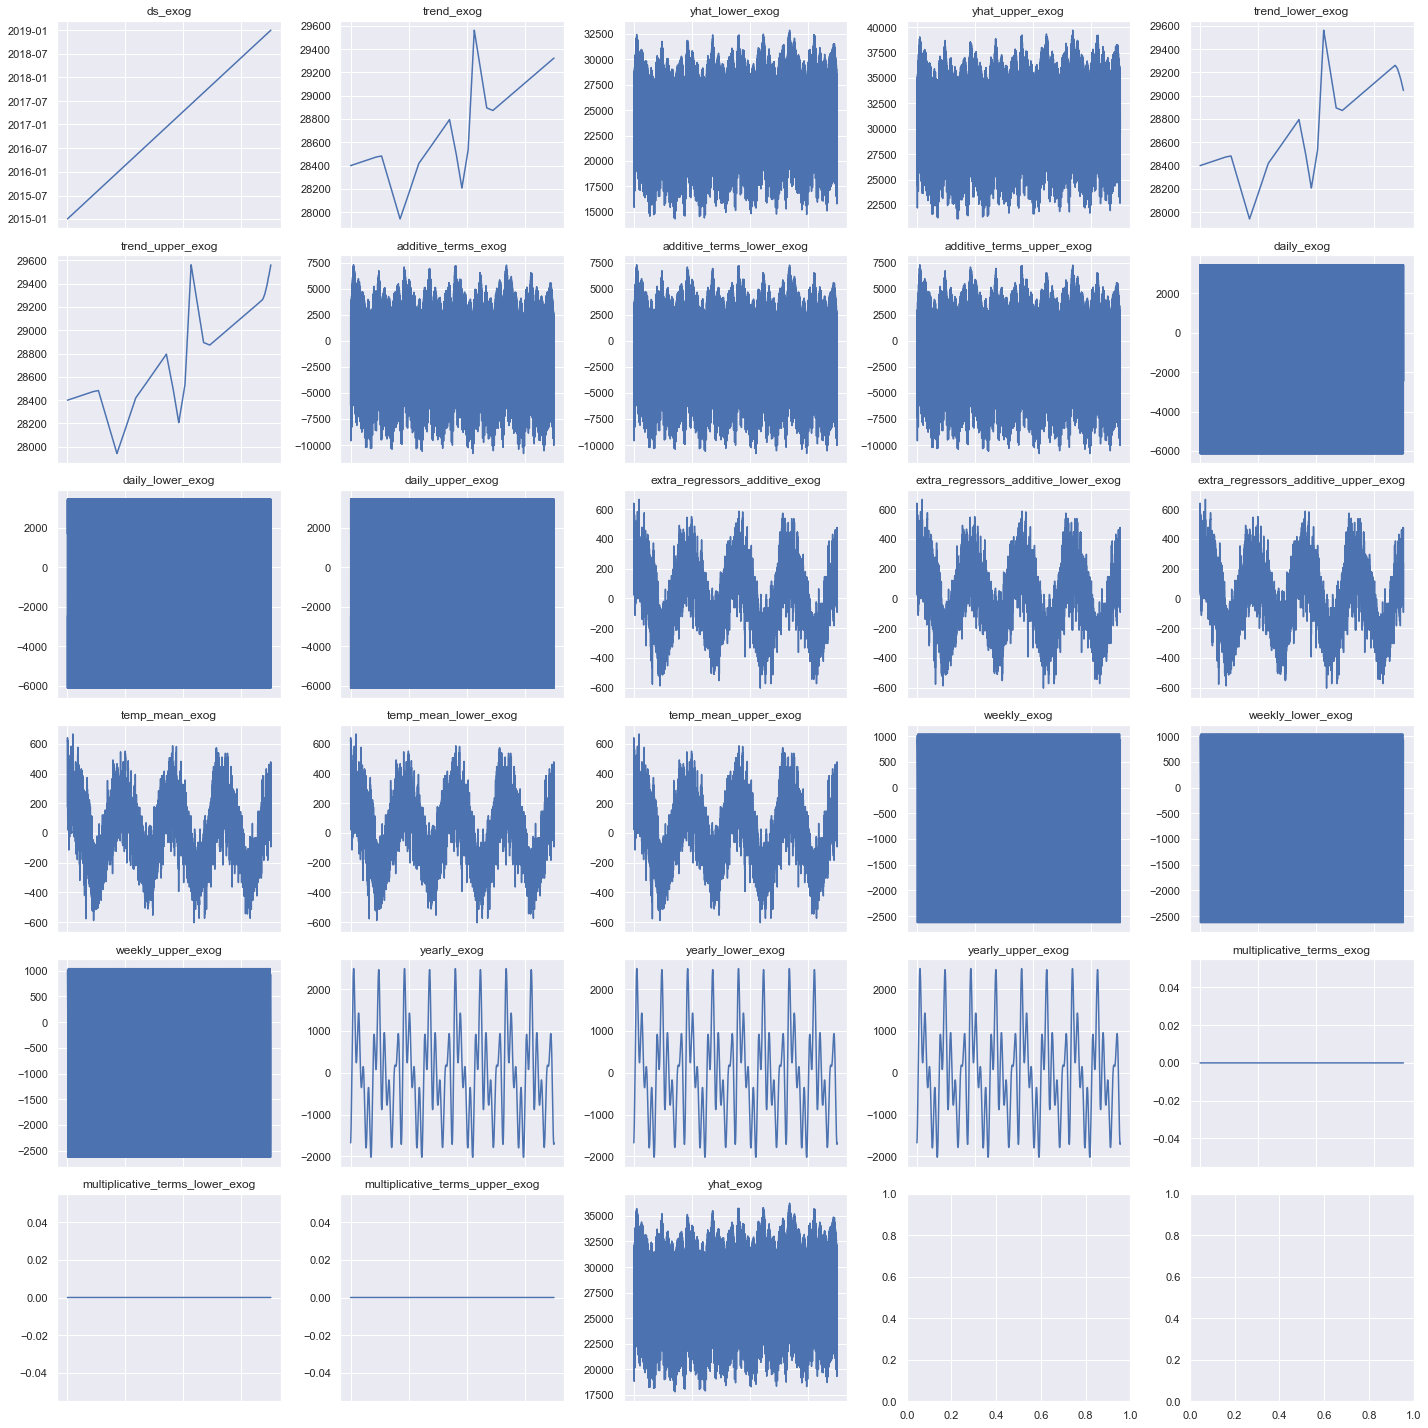

In [37]:
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(20,20), tight_layout=True)

for i, columns in enumerate(forecast.columns):
    row = i // 5
    col = i % 5
    axs[row][col].plot(forecast[columns])
    axs[row][col].set_title(columns)
    axs[row][col].set_xticklabels([])

plt.show()

**As discussed at the begining of this notebook there are parameters that can be set when fitting prophet. These are listed out below and can be used to improve the forecast**

**Options for the Prophet class**
- growth: linear or logistic trend.
- changepoints: dates at which to include potential changepoints.
- n_changepoints: number of potential changepoints.
- changepoint_range: proportion of history in which trend changepoints will be estimated.
- yearly_seasonality: fit yearly seasonality.
- weekly_seasonality: fit weekly seasonality.
- daily_seasonality: fit daily seasonality.
- holidays: pd.DataFrame with columns holiday (string) and ds (date type) and optionally columns lower_window and upper_window which specify a range of days around the date to be included as holidays.
- seasonality_mode: additive (default) or multiplicative.
- seasonality_prior_scale: parameter modulating the strength of the seasonality model.
- holidays_prior_scale: parameter modulating the strength of the holiday components model.
- changepoint_prior_scale: parameter modulating the flexibility of the automatic changepoint selection.
- mcmc_samples: if greater than 0, will do full Bayesian inference with the specified number of MCMC samples. If 0, will do MAP estimation.
- interval_width: float width of the uncertainty intervals provided for the forecast.
- uncertainty_samples: number of simulated draws used to estimate uncertainty intervals.
- stan_backend: specifies the Stan backend to use.